In [1]:
from src.model.sam import CustomSamAutomaticMaskGenerator, load_sam
from segment_anything.modeling.sam import Sam
model_type = "vit_h"
checkpoint_dir =  "datasets/bop23_challenge/pretrained/segment-anything"
sam_model = load_sam(model_type, checkpoint_dir)
custom_sam_model = CustomSamAutomaticMaskGenerator(sam=sam_model)


In [2]:
def move_to_device(segmentor_model, device="cuda:0"):
    # if there is predictor in the model, move it to device
    if hasattr(segmentor_model, "predictor"):
        segmentor_model.predictor.model = (
            segmentor_model.predictor.model.to(device)
        )
    else:
        segmentor_model.model.setup_model(device=device, verbose=True)
move_to_device(custom_sam_model)

In [3]:
from PIL import Image
import torch
import numpy as np
from src.model.utils import Detections
rgb_path = "nhap/1.png"
rgb = Image.open(rgb_path).convert("RGB")
detections = custom_sam_model.generate_masks(np.array(rgb))

In [4]:
detections["masks"][0].shape

torch.Size([4016, 2756])

In [5]:
import matplotlib.pyplot as plt
def matplotlib_imshow(binary_mask):
    # Convert the boolean mask to an integer mask
    binary_mask_int = binary_mask.int()

    # Convert the binary mask to a NumPy array
    binary_mask_np = binary_mask_int.cpu().numpy()

    # Plot the binary mask
    plt.imshow(binary_mask_np, cmap='gray')
    plt.title('Binary Mask')
    plt.axis('off')  # Hide axis
    plt.show()

In [6]:
def extract_object_by_mask(image, mask, width: int = 512):
    mask = Image.fromarray(mask)
    masked_image = Image.composite(
        image, Image.new("RGB", image.size, (0, 0, 0)), mask)
    cropped_image = masked_image.crop(masked_image.getbbox())
    new_height = width * cropped_image.height // cropped_image.width
    return cropped_image.resize((width, new_height))

In [7]:
detections["boxes"].shape

torch.Size([74, 4])

In [8]:
masked_images = []
for mask in detections["masks"].cpu():
    binary_mask = np.array(mask) * 255
    binary_mask = binary_mask.astype(np.uint8)
    masked_image = extract_object_by_mask(rgb, binary_mask)
    masked_images.append(masked_image)

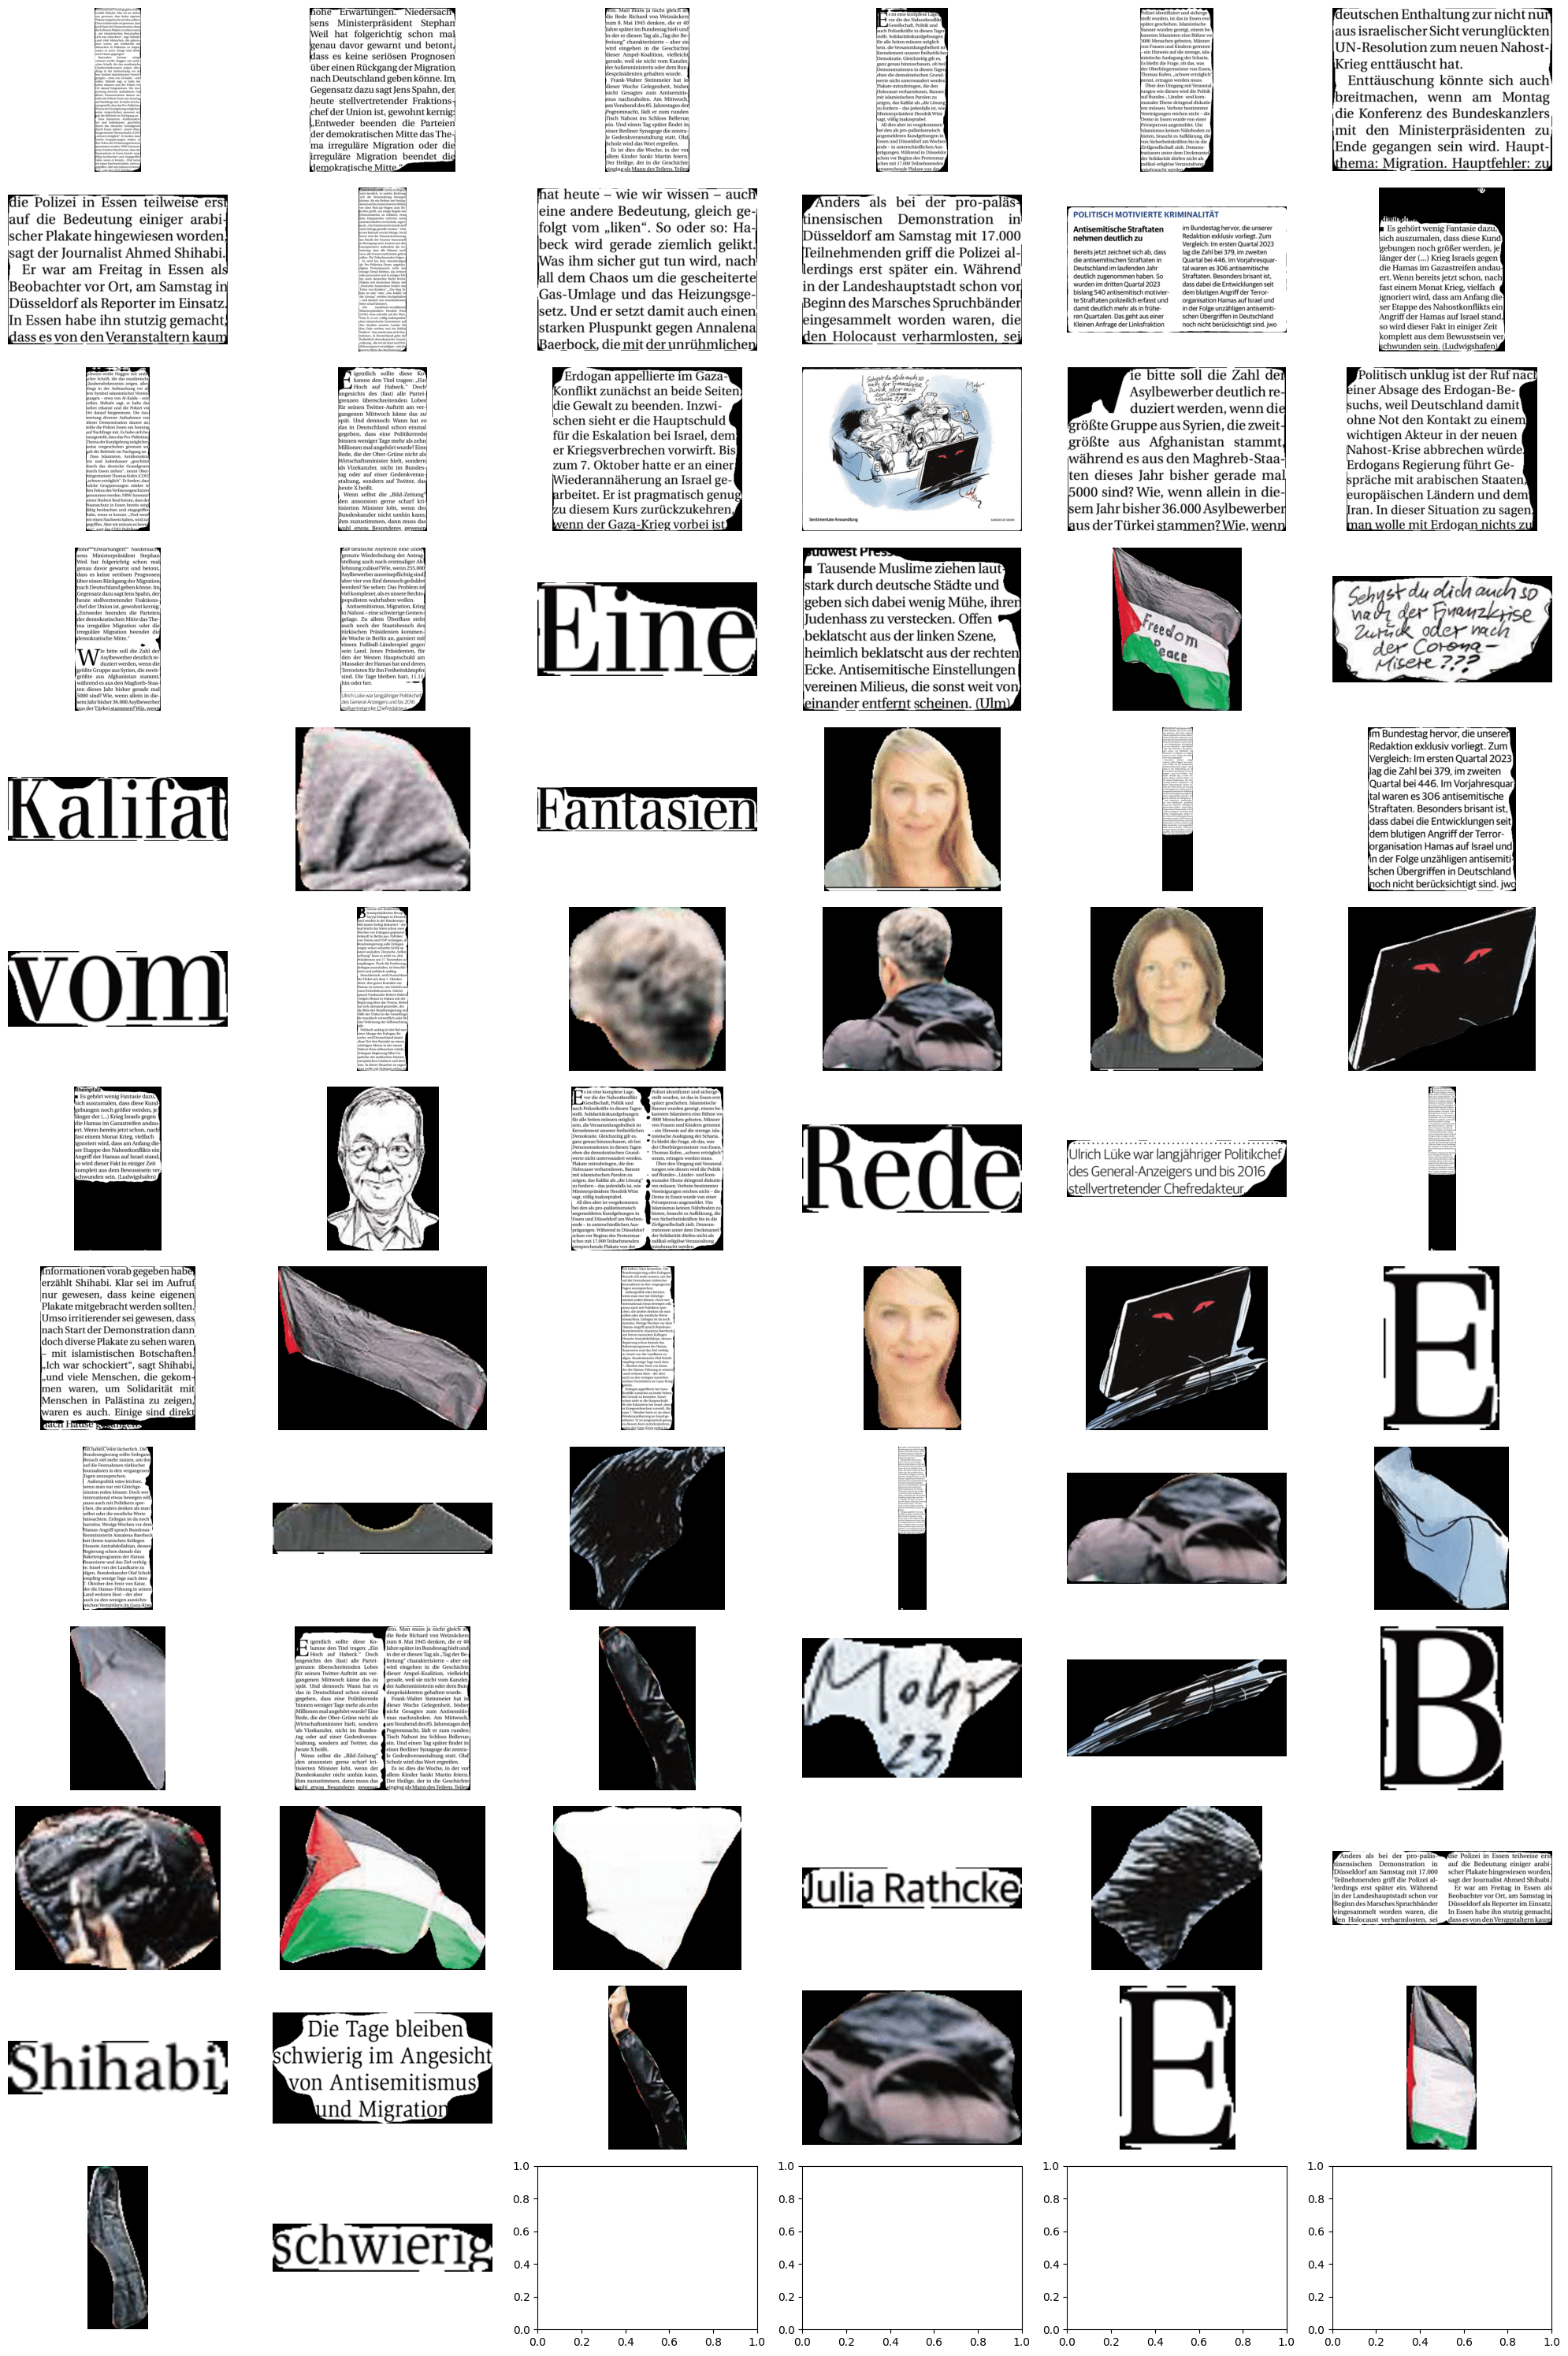

In [9]:
# Visualize proposals
import matplotlib.pyplot as plt
from math import ceil
def plot_images(images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 30))
    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break
        ax.imshow(images[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Define the number of rows and columns in the grid
rows = ceil(len(masked_images) / 6)
cols = 6
# Plot the masked_images array in a grid
plot_images(masked_images, rows, cols) 

In [10]:
def show_anns(anns):
    if len(anns) == 0:
        return
    # sorted(anns, key=(lambda x: x['area']), reverse=True)
    sorted_anns = anns['masks'].cpu()
    
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0].shape[0],
                  sorted_anns[0].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = np.array(ann, dtype=bool)
        if m.mean() > 0.5:
            continue
        color_mask = np.concatenate([np.random.random(3), [0.6]])
        img[m] = color_mask
    
    ax.imshow(img)

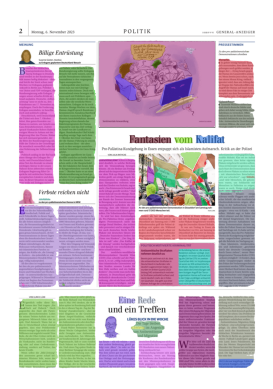

In [11]:
# SAM
plt.imshow(np.array(rgb))
show_anns(detections)
plt.axis('off')
save_path = "nhap/demo.png"
if save_path:
    plt.savefig(save_path, bbox_inches='tight')
plt.show()


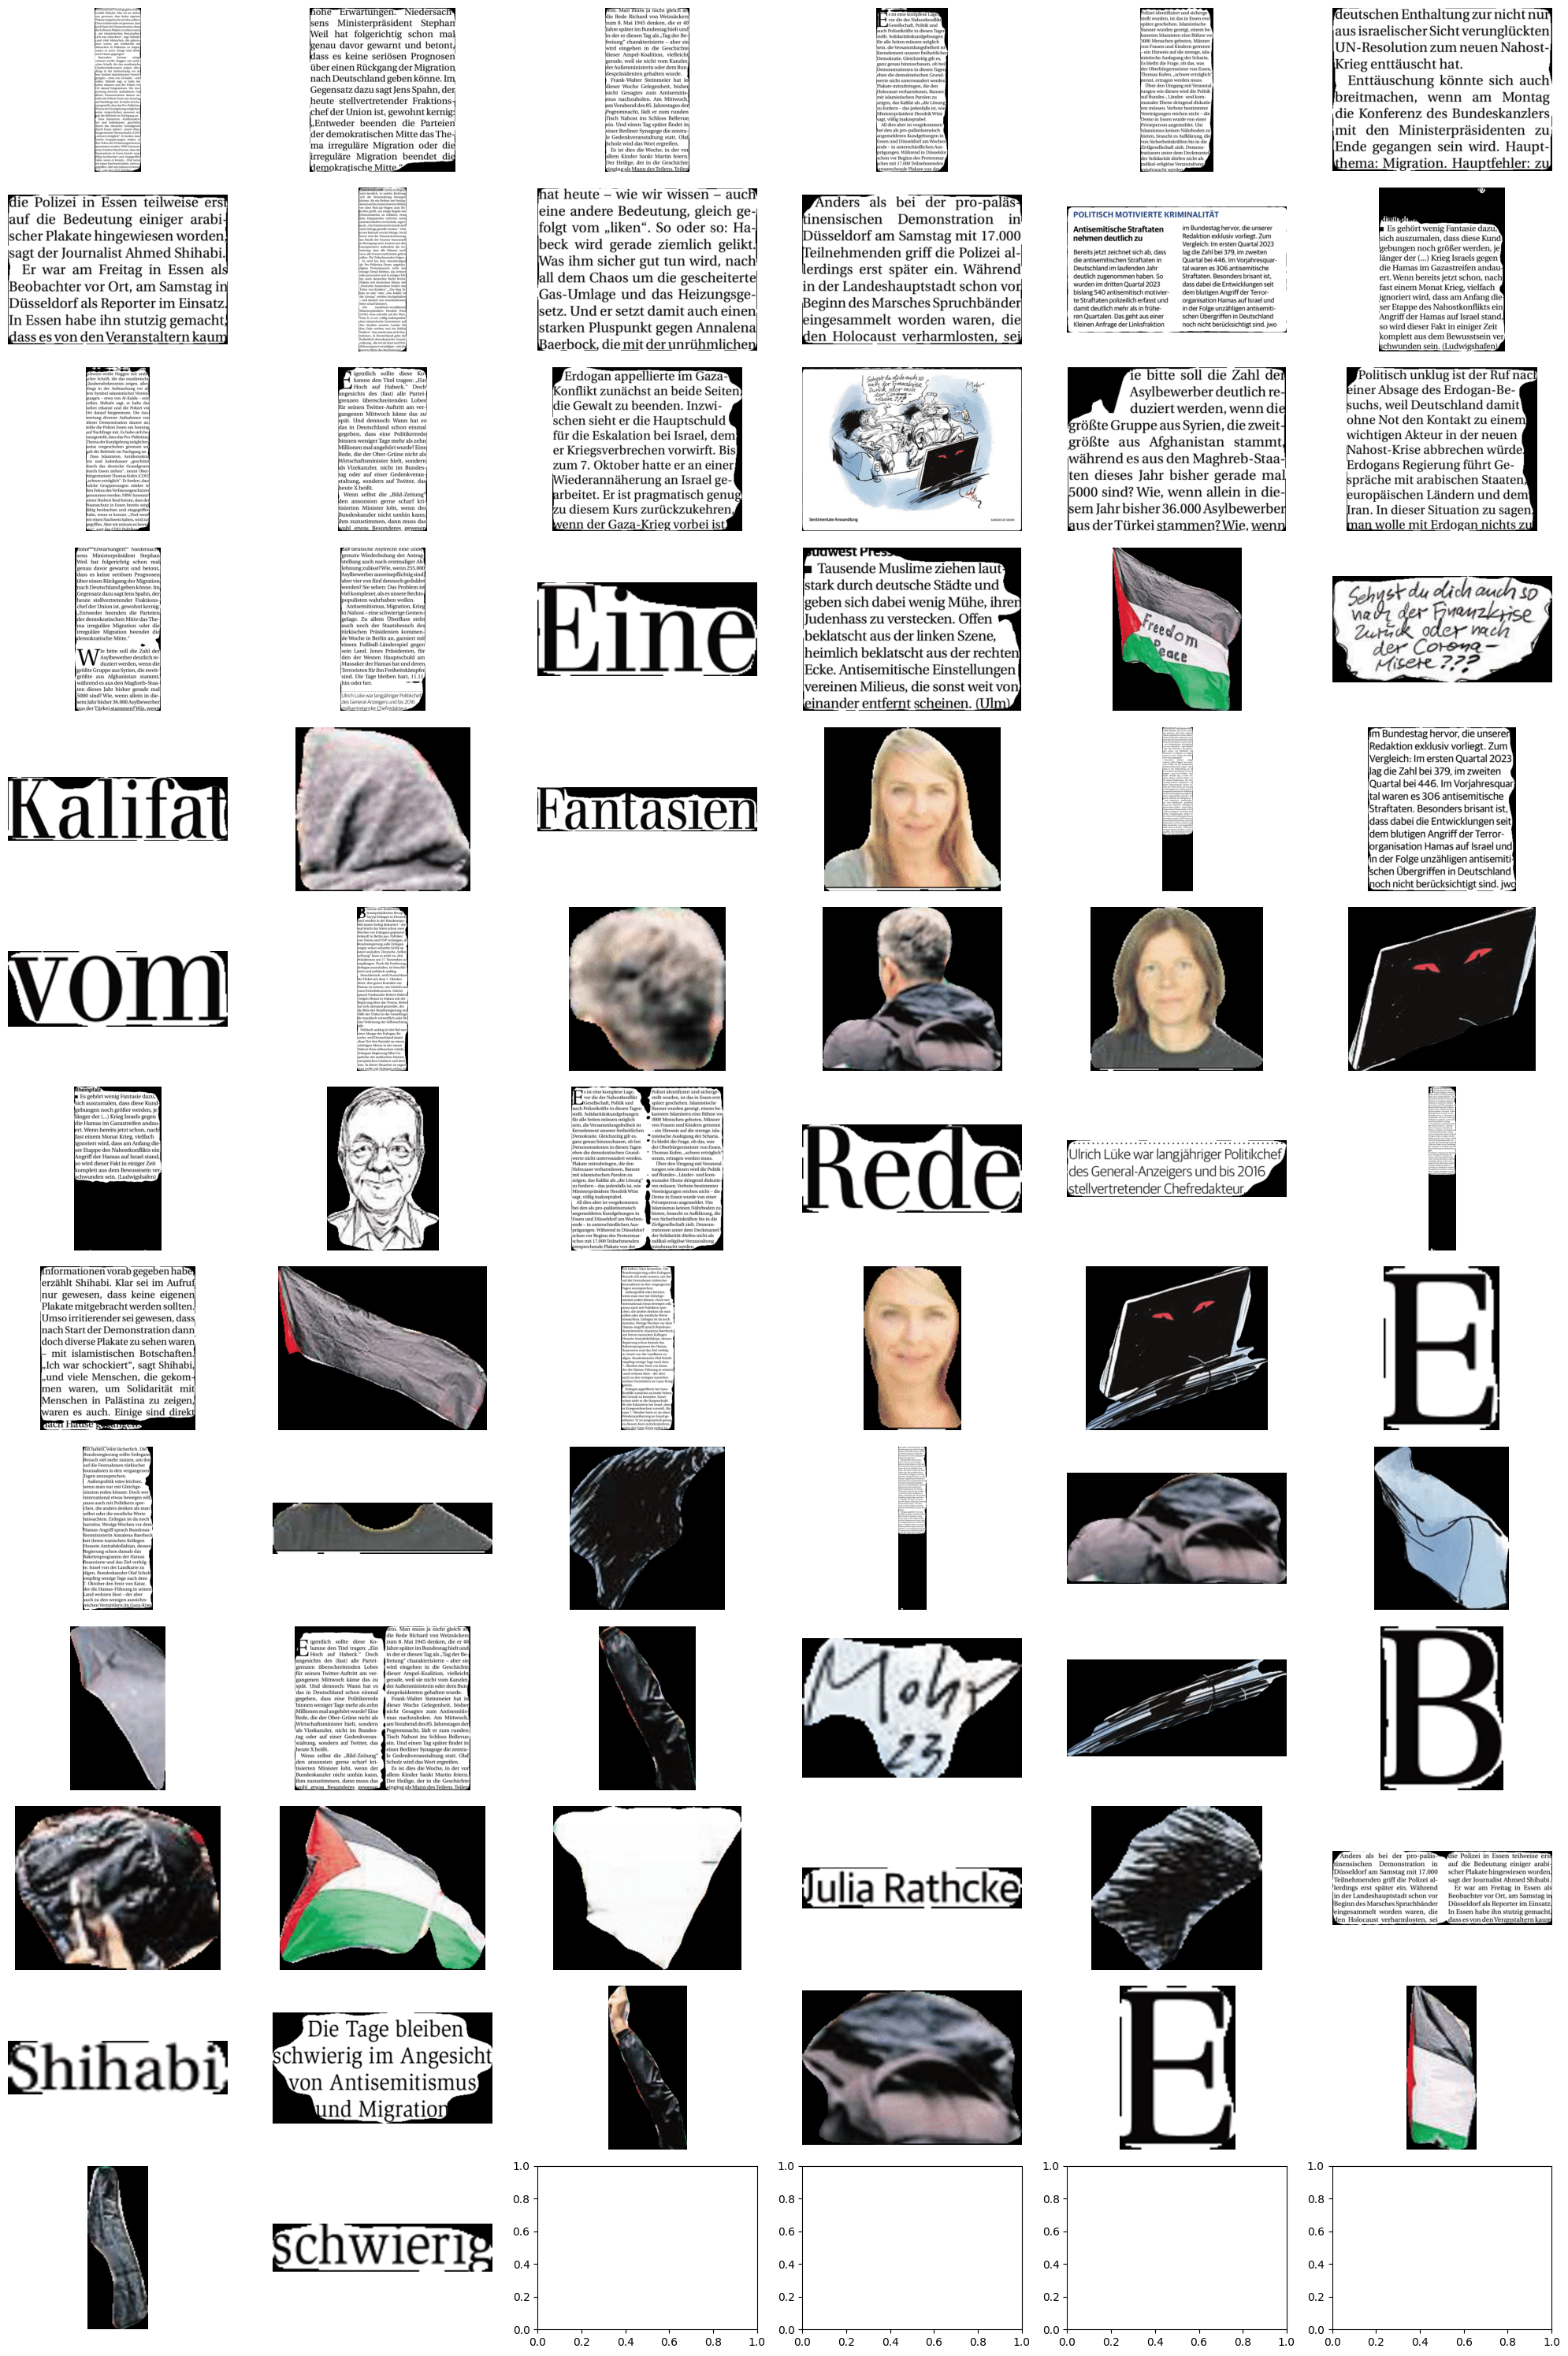

In [12]:
import matplotlib.pyplot as plt
from math import ceil


def plot_images(images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 30))
    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break

        ax.imshow(images[i])
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# Define the number of rows and columns in the grid

rows = ceil(len(masked_images) / 6)
cols = 6

# Plot the masked_images array in a grid

plot_images(masked_images, rows, cols)